In [96]:
import wandb
import pandas as pd
import os
os.environ["WANDB_BASE_URL"] = "https://api.bandw.top" 
# 登录 wandb
wandb.login()

# origin_float16	ac-milan/verl_train_gnode5/gscirgoa
# origin	ac-milan/verl_train_gnode5/i41hd1u6
# en_di_2_23	ac-milan/verl_train_gnode5/g96tqll8
# er_pyr_3	ac-milan/verl_train_gnode5/y5wbrs1d


# origin	ac-milan/verl_train/vke8gix4
# er_di_2_3	ac-milan/verl_train/wxh4hh13


# 获取项目中的所有 run
api = wandb.Api()
run = api.run("ac-milan/verl_train_gnode5/i41hd1u6")
# ac-milan/verl_train/vke8gix4
run2 = api.run("ac-milan/verl_train_gnode5/g96tqll8")
df2 = run2.history()

In [97]:
df = run.history()
df

,cal/overall/layer_1/Curvature diff 2/min,filtered_response_length/max,cal/incorrect/layer_1/Effective Rank diff/mean,timing_per_token_ms/gen,cal/incorrect/layer_1/Curvature/min,val/cal_correct/simplelr_qwen/layer_1/Response Entropy 1,cal/overall/layer_1/Effective Rank diff/min,response_length/incorrect/mean,actor/kl_loss,critic/returns/max,...,actor/entropy_loss,val/test_score_0/simplelr_qwen,critic/score/max,cal/overall/layer_1/Response Entropy 1/mean,response_length/correct/max,critic/advantages/min,cal/incorrect/layer_1/Curvature diff 2/min,prompt_length/max,cal/correct/layer_1/Effective Rank diff/mean,val/cal_correct/simplelr_qwen/layer_1/Response Entropy 1 diff 2
0,NaN,NaN,NaN,NaN,NaN,2.435775,NaN,NaN,NaN,NaN,...,NaN,0.399770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011491
1,-0.042630,1280.0,0.058858,3.502980,1.516117,NaN,-0.391153,569.378723,0.013566,2.046875,...,1.628630,NaN,1.0,2.382010,1280.0,-2.046875,-0.042630,193.0,0.052028,NaN
2,-0.061789,1280.0,0.036023,3.290641,1.224805,NaN,-0.301756,661.272278,0.011825,2.046875,...,1.653882,NaN,1.0,2.338169,1223.0,-2.046875,-0.061789,252.0,0.043200,NaN
3,-0.028112,1280.0,0.020814,2.917398,0.000000,NaN,-0.616825,664.476685,0.014356,2.046875,...,1.639454,NaN,1.0,2.387587,1280.0,-2.046875,-0.028112,167.0,0.063218,NaN
4,-0.030063,1280.0,0.040622,3.314069,1.410489,NaN,-0.453825,659.527466,0.005749,1.968750,...,1.728988,NaN,1.0,2.416309,1280.0,-2.046875,-0.030063,163.0,0.028477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,-0.012529,1280.0,-0.030602,3.060997,1.952750,NaN,-0.300707,640.305359,3.693055,2.031250,...,0.119158,NaN,1.0,3.688565,1168.0,-2.046875,-0.007392,162.0,0.035824,NaN
295,-0.009099,1280.0,-0.018550,3.475563,1.516267,3.488710,-0.326598,589.895081,2.284662,2.031250,...,0.175628,0.452765,1.0,3.713801,1040.0,-2.046875,-0.008821,169.0,0.031227,0.010166
296,-0.006232,1280.0,-0.007172,3.135336,1.969223,NaN,-0.303632,536.902771,3.457039,2.031250,...,0.213836,NaN,1.0,3.655059,1280.0,-2.046875,-0.005473,149.0,0.064504,NaN
297,-0.047622,1280.0,-0.005436,3.069789,1.967510,NaN,-0.293465,499.288300,4.550124,2.031250,...,0.133084,NaN,1.0,3.586875,1280.0,-2.031250,-0.047622,123.0,0.109865,NaN


In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def smooth_data(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

def plot_metrics(df, mode="cal", stat="mean", max_step=None, window_size=10, show_raw=True):
    metrics = ['Response Entropy 1', 'Effective Rank', 'Curvature']
    diffs = ['', ' diff', ' diff 2']
    categories = ['overall', 'correct', 'incorrect']

    # 构建匹配模式
    matched_cols = {}
    for metric in metrics:
        for diff in diffs:
            base_name = f"{metric}{diff}"
            for category in categories:
                if mode == "cal":
                    col_name = f"{mode}/{category}/layer_1/{base_name}/{stat}"
                elif mode == "val":
                    prefix = {"overall": "cal_overall", "correct": "cal_correct", "incorrect": "cal_incorrect"}[category]
                    col_name = f"val/{prefix}/simplelr_qwen/layer_1/{base_name}"

                if col_name in df.columns:
                    matched_cols[(metric, diff, category)] = col_name

    # 检查是否有数据
    if not matched_cols:
        raise ValueError(f"未找到任何匹配的列，请检查 mode='{mode}', stat='{stat}'")

    # 绘图设置
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    colors = {'overall': 'blue', 'correct': 'green', 'incorrect': 'red'}

    for i, metric in enumerate(metrics):
        for j, diff in enumerate(diffs):
            ax = axes[i, j]
            found = False
            for category in categories:
                key = (metric, diff, category)
                if key not in matched_cols:
                    continue
                col_name = matched_cols[key]
                data = df[col_name]
                steps = df["_step"] if "_step" in df.columns else np.arange(len(data))

                # 截断到 max_step
                if max_step is not None:
                    mask = steps <= max_step
                    steps = steps[mask]
                    data = data[mask]

                smoothed = smooth_data(data, window_size)

                if show_raw:
                    ax.plot(steps, data, color=colors[category], alpha=0.3, linewidth=1, label=f"{category} raw")
                ax.plot(steps, smoothed, label=f"{category}", color=colors[category], linewidth=2)

                found = True

            ax.set_title(f"{metric} {diff}")
            if found:
                ax.legend()
            ax.grid(True)

    plt.suptitle(f"Metrics ({mode}, stat: {stat})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

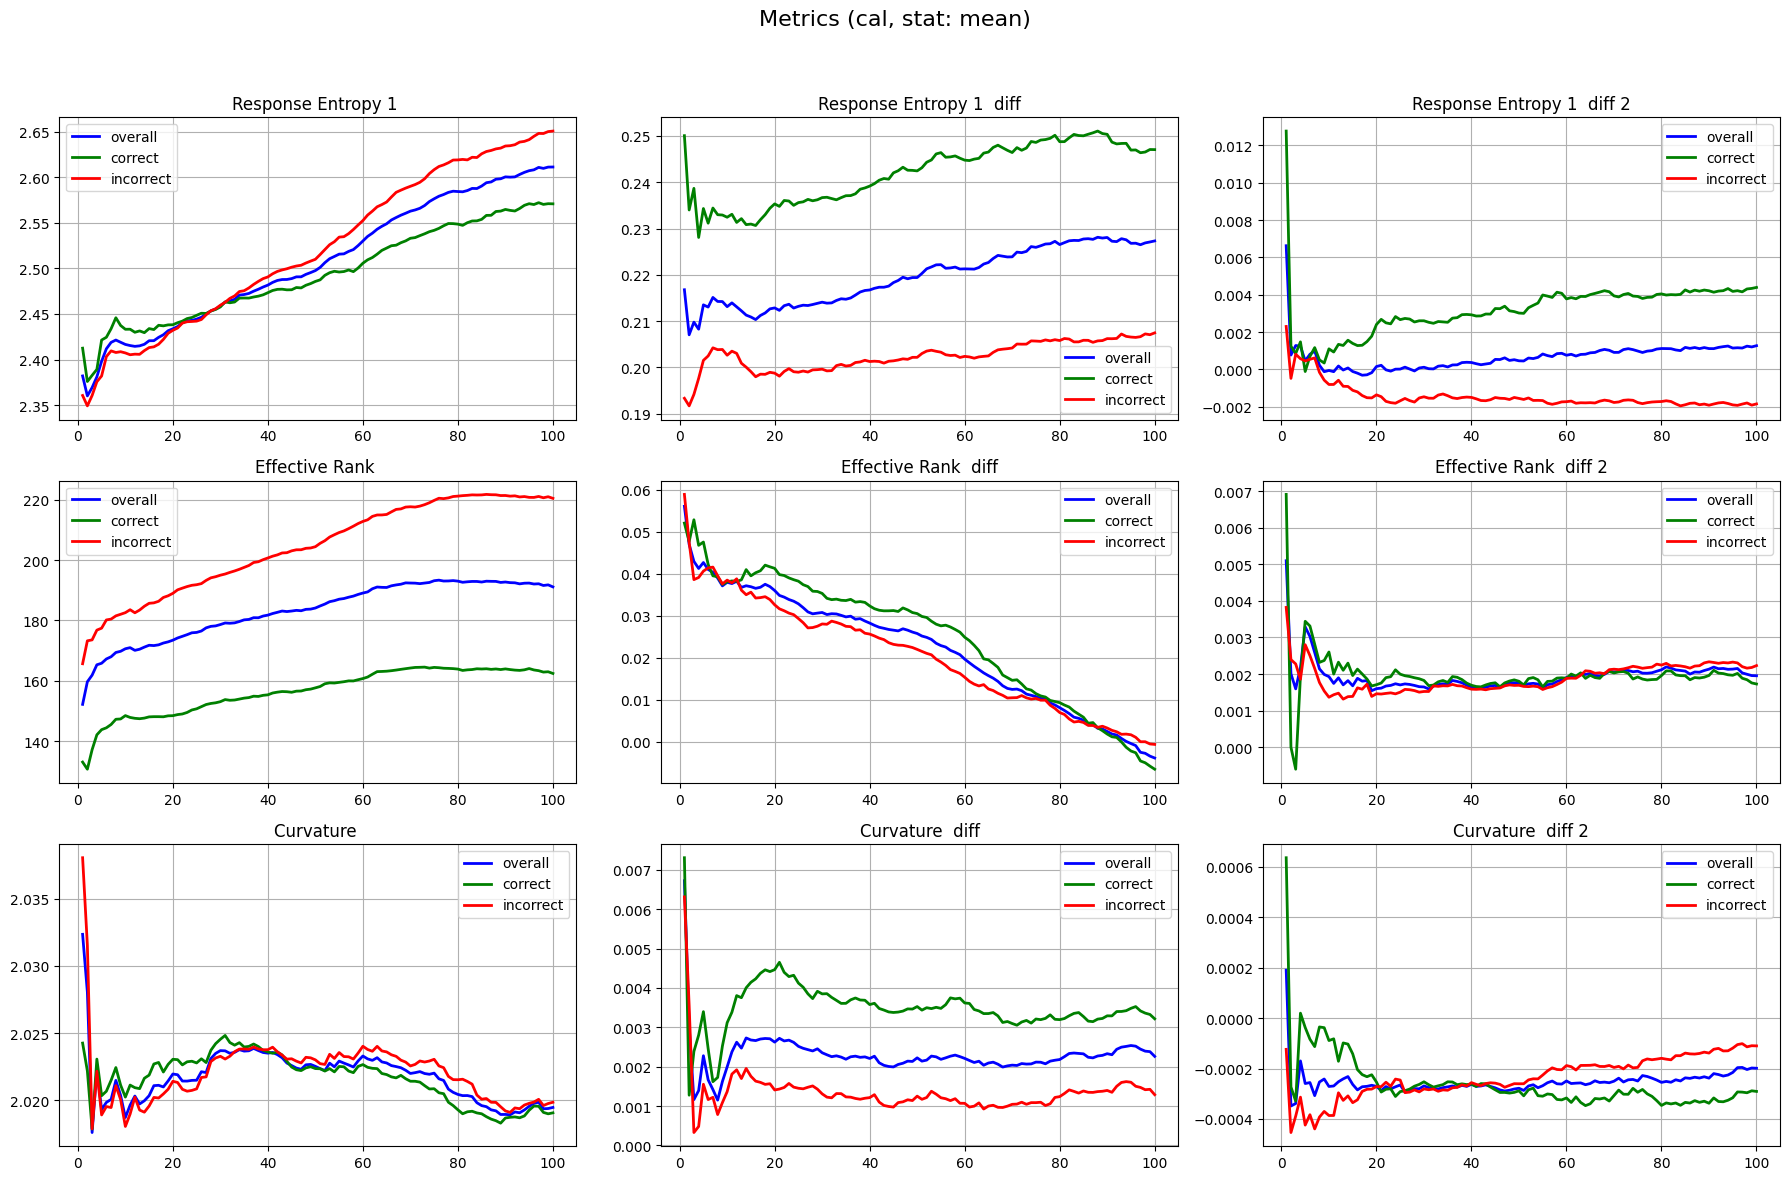

In [99]:
# 假设 history_df 是你从 wandb.run.history() 或本地加载的 DataFrame
plot_metrics(
    df=df,
    mode='cal',          # 'cal' 表示训练数据，'val' 表示测试数据
    stat='mean',         # 可选 'mean', 'max', 'min'
    max_step=100,       # 最大 step 数
    window_size=50,      # 平滑窗口大小
    show_raw=False        # 是否显示原始曲线
)

In [100]:
def compare_metrics(
    df1,
    df2,
    label1="Run A",
    label2="Run B",
    mode="cal",
    stat="mean",
    max_step=None,
    window_size=10,
    show_raw=True,
    categories=("overall", "correct", "incorrect")  # ✅ 新增参数
):
    """
    使用 plot_metrics 的逻辑，在 df1 和 df2 上分别提取数据，并在同一张图中进行对比。
    
    参数与 plot_metrics 类似，新增：
        label1, label2: 两个 run 的图例标签
        categories: 要显示的类别，如 ("overall", "correct")
    """
    metrics = ['Response Entropy 1', 'Effective Rank', 'Curvature']
    diffs = ['', ' diff', ' diff 2']

    # 构建匹配模式（针对 df1）
    def get_matched_cols(df, mode, stat):
        matched_cols = {}
        for metric in metrics:
            for diff in diffs:
                base_name = f"{metric}{diff}"
                for category in categories:  # ✅ 改为使用传入的 categories 参数
                    if mode == "cal":
                        col_name = f"{mode}/{category}/layer_1/{base_name}/{stat}"
                    elif mode == "val":
                        prefix = {"overall": "cal_overall", "correct": "cal_correct", "incorrect": "cal_incorrect"}[category]
                        col_name = f"val/{prefix}/simplelr_qwen/layer_1/{base_name}"

                    if col_name in df.columns:
                        matched_cols[(metric, diff, category)] = col_name
        return matched_cols

    cols1 = get_matched_cols(df1, mode, stat)
    cols2 = get_matched_cols(df2, mode, stat)

    # 绘图设置
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    colors = {'overall': 'blue', 'correct': 'green', 'incorrect': 'red'}

    for i, metric in enumerate(metrics):
        for j, diff in enumerate(diffs):
            ax = axes[i, j]
            found = False
            for category in categories:  # ✅ 这里也改为使用传入的 categories 参数
                key = (metric, diff, category)

                # 获取 df1 数据
                if key in cols1:
                    col_name = cols1[key]
                    data = df1[col_name]
                    steps = df1["_step"] if "_step" in df1.columns else np.arange(len(data))

                    if max_step is not None:
                        mask = steps <= max_step
                        steps = steps[mask]
                        data = data[mask]

                    smoothed = smooth_data(data, window_size)

                    ax.plot(steps, smoothed, label=f"{label1} - {category}", color=colors[category], linewidth=2)

                    if show_raw:
                        ax.plot(steps, data, color=colors[category], alpha=0.3, linewidth=1)

                # 获取 df2 数据
                if key in cols2:
                    col_name = cols2[key]
                    data = df2[col_name]
                    steps = df2["_step"] if "_step" in df2.columns else np.arange(len(data))

                    if max_step is not None:
                        mask = steps <= max_step
                        steps = steps[mask]
                        data = data[mask]

                    smoothed = smooth_data(data, window_size)

                    ax.plot(steps, smoothed, label=f"{label2} - {category}", color=colors[category], linewidth=2, linestyle='--')

                    if show_raw:
                        ax.plot(steps, data, color=colors[category], alpha=0.3, linewidth=1, linestyle='--')

                found = True

            ax.set_title(f"{metric} {diff}")
            if found:
                ax.legend()
            ax.grid(True)

    plt.suptitle(f"Comparison: {label1} vs {label2} ({mode}, stat: {stat})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

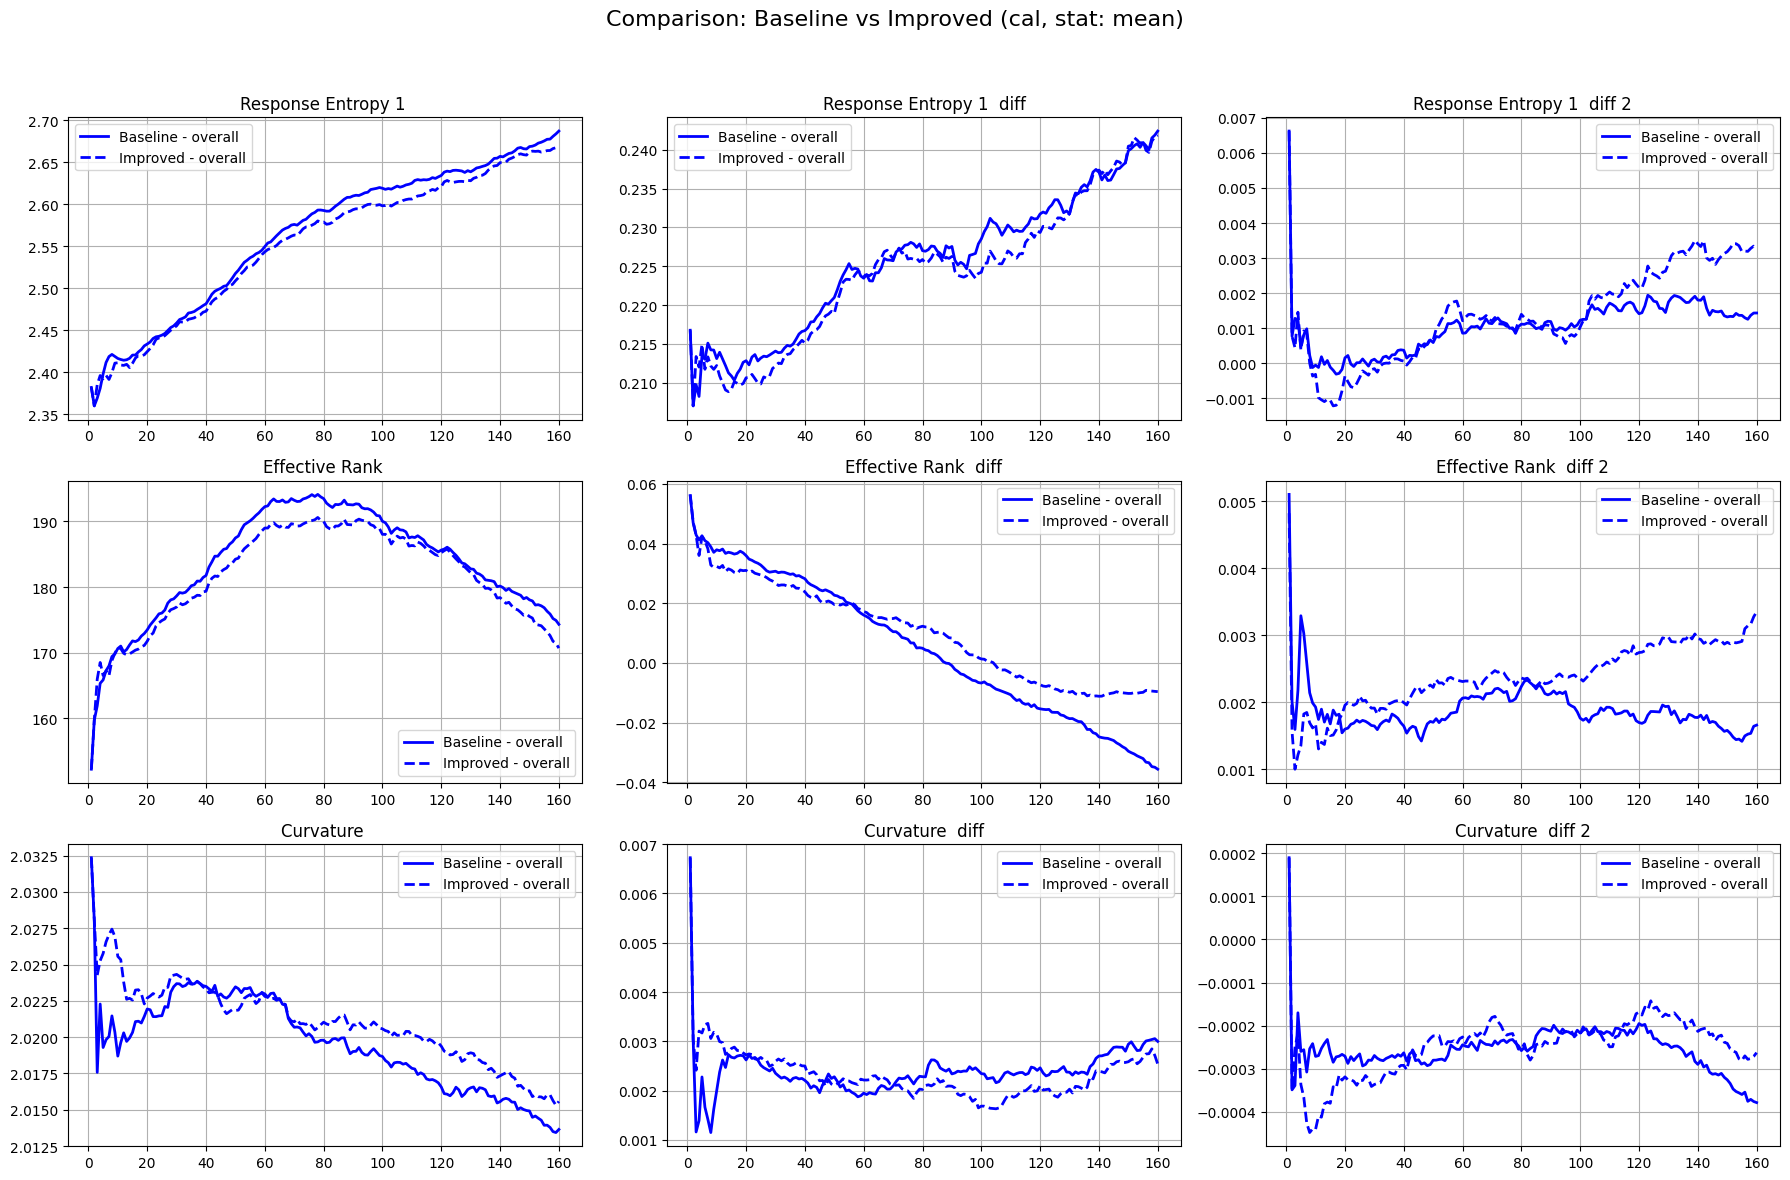

In [102]:
# 假设 df1 和 df2 是你从 wandb.run.history() 或本地加载的 DataFrame
compare_metrics(
    df1=df,
    df2=df2,
    label1="Baseline",
    label2="Improved",
    mode="cal",
    stat="mean",
    max_step=160,
    window_size=40,
    show_raw=False,
    categories=("overall",) # ("overall", "correct", "incorrect")
)

In [34]:
df

,cal/overall/layer_1/Effective Rank diff 2/mean,val/test_correctness/simplelr_qwen,cal/overall/layer_1/Response Entropy 1/mean,timing_s/ref,cal/overall/layer_1/Response Entropy 1 diff 2/mean,timing_s/save_checkpoint,prompt_length/mean,cal/overall/layer_1/Curvature diff 2/max,cal/incorrect/layer_1/Response Entropy 1/min,val/cal_overall/simplelr_qwen/layer_1/Effective Rank diff,...,cal/correct/layer_1/Effective Rank/max,timing_s/adv,val/cal_overall/simplelr_qwen/layer_1/Curvature diff,cal/incorrect/layer_1/Response Entropy 1/mean,cal/incorrect/layer_1/Effective Rank/max,timing_per_token_ms/update_actor,cal/correct/layer_1/Curvature/min,cal/incorrect/layer_1/Curvature diff/mean,global_seqlen/min,timing_s/testing
0,NaN,0.645161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.020092,...,NaN,NaN,-0.000685,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.004819,NaN,2.382010,61.761015,0.006626,NaN,84.520836,0.033620,0.000009,NaN,...,387.803162,9.094763,NaN,2.360578,376.931000,1.263232,1.930820,0.006312,34498.0,NaN
2,-0.001692,NaN,2.338169,59.951257,-0.005099,NaN,88.854164,0.028309,0.000012,NaN,...,279.271271,11.709496,NaN,2.337765,361.950745,1.124516,1.698431,0.000789,47925.0,NaN
3,-0.000120,NaN,2.435812,60.150549,-0.000219,NaN,92.604164,0.035175,0.000000,NaN,...,390.893921,7.092708,NaN,2.427018,367.915436,1.090723,1.769869,0.000618,45613.0,NaN
4,0.001852,NaN,2.428982,59.263565,0.004498,NaN,95.958336,0.029262,0.000003,NaN,...,373.061188,9.095137,NaN,2.398831,355.937256,1.092064,1.948445,0.006813,47117.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.001660,NaN,3.239954,59.946820,-0.000680,NaN,82.458336,0.007401,1.826679,NaN,...,369.865479,7.992356,NaN,3.205200,406.266754,1.149733,1.980299,-0.002518,39838.0,NaN
235,0.003366,0.656682,3.354404,60.114240,0.000416,NaN,95.750000,0.032235,2.058889,-0.032222,...,417.205872,6.834224,-0.005491,3.376289,415.166199,1.103854,1.995268,-0.002926,41959.0,3089.503864
236,0.003042,NaN,3.387549,60.837184,0.004318,NaN,88.937500,0.009079,0.880511,NaN,...,368.226807,7.637290,NaN,3.413193,469.815002,1.077701,1.948416,-0.004252,41902.0,NaN
237,-0.000513,NaN,3.343510,57.461700,-0.000850,NaN,86.937500,0.011387,1.091827,NaN,...,415.617218,5.560541,NaN,3.240775,401.143768,1.231634,1.980384,-0.004265,40821.0,NaN


In [35]:
df2

,cal/overall/layer_1/Curvature diff 2/min,filtered_response_length/max,cal/incorrect/layer_1/Effective Rank diff/mean,timing_per_token_ms/gen,cal/incorrect/layer_1/Curvature/min,val/cal_correct/simplelr_qwen/layer_1/Response Entropy 1,cal/overall/layer_1/Effective Rank diff/min,response_length/incorrect/mean,actor/kl_loss,critic/returns/max,...,actor/entropy_loss,val/test_score_0/simplelr_qwen,critic/score/max,cal/overall/layer_1/Response Entropy 1/mean,response_length/correct/max,critic/advantages/min,cal/incorrect/layer_1/Curvature diff 2/min,prompt_length/max,cal/correct/layer_1/Effective Rank diff/mean,val/cal_correct/simplelr_qwen/layer_1/Response Entropy 1 diff 2
0,NaN,NaN,NaN,NaN,NaN,2.435775,NaN,NaN,NaN,NaN,...,NaN,0.399770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011491
1,-0.042630,1280.0,0.058858,3.502980,1.516117,NaN,-0.391153,569.378723,0.013566,2.046875,...,1.628630,NaN,1.0,2.382010,1280.0,-2.046875,-0.042630,193.0,0.052028,NaN
2,-0.061789,1280.0,0.036023,3.290641,1.224805,NaN,-0.301756,661.272278,0.011825,2.046875,...,1.653882,NaN,1.0,2.338169,1223.0,-2.046875,-0.061789,252.0,0.043200,NaN
3,-0.028112,1280.0,0.020814,2.917398,0.000000,NaN,-0.616825,664.476685,0.014356,2.046875,...,1.639454,NaN,1.0,2.387587,1280.0,-2.046875,-0.028112,167.0,0.063218,NaN
4,-0.030063,1280.0,0.040622,3.314069,1.410489,NaN,-0.453825,659.527466,0.005749,1.968750,...,1.728988,NaN,1.0,2.416309,1280.0,-2.046875,-0.030063,163.0,0.028477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,-0.012529,1280.0,-0.030602,3.060997,1.952750,NaN,-0.300707,640.305359,3.693055,2.031250,...,0.119158,NaN,1.0,3.688565,1168.0,-2.046875,-0.007392,162.0,0.035824,NaN
295,-0.009099,1280.0,-0.018550,3.475563,1.516267,3.488710,-0.326598,589.895081,2.284662,2.031250,...,0.175628,0.452765,1.0,3.713801,1040.0,-2.046875,-0.008821,169.0,0.031227,0.010166
296,-0.006232,1280.0,-0.007172,3.135336,1.969223,NaN,-0.303632,536.902771,3.457039,2.031250,...,0.213836,NaN,1.0,3.655059,1280.0,-2.046875,-0.005473,149.0,0.064504,NaN
297,-0.047622,1280.0,-0.005436,3.069789,1.967510,NaN,-0.293465,499.288300,4.550124,2.031250,...,0.133084,NaN,1.0,3.586875,1280.0,-2.031250,-0.047622,123.0,0.109865,NaN
